In [40]:
# Import internal libraries
import glob, json

# Import external libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [41]:
# Analyze reliability, bandwidth, energy
data = []
deadcols = np.genfromtxt("../settings/dead_columns.csv", delimiter=",")
refdir = "../lfsr"
for bpc in range(1, 3):
  refvec = np.loadtxt(f"{refdir}/lfsr_{bpc}bpc_data.txt", delimiter=',', dtype=np.int8)
  for alias in glob.glob(f"../settings/opt/{bpc}bpc*.json"):
    alias = alias.split("/")[-1][:-5]
    print(alias)
    for mode in ["cb", "lfsr"]:
      for att in [1, 2, 4, 8] + list(range(16, 256, 32)) + [255]:
        # Real max attempts
        att = (att & 31) << (att >> 5)

        # Load and compute data
        try:
          diag = json.load(open(f"data/diag/diag_{mode}_{alias}_{att}.json"))
          dt = np.loadtxt(f"data/dt/dt_{mode}_{alias}_{att}.csv", delimiter=',')
        except OSError:
          continue
        try:
          ivdd = np.loadtxt(f"data/power/vdd_{mode}_power_{alias}_{att}.csv", delimiter=',')
          ivddio = np.loadtxt(f"data/power/vddio_{mode}_power_{alias}_{att}.csv", delimiter=',')
        except OSError:
          ivdd = np.array([0])
          ivddio = np.array([0])

        # Load data into confmat
        try:
            confmat = np.loadtxt(f"data/confmat/confmat_{mode}_{alias}_{att}.csv", delimiter=',')
        except OSError:
            try:
                postread = np.loadtxt(f"data/postread/postread_{mode}_{alias}_{att}.csv", delimiter=',', dtype=np.int8)
                confmat = np.zeros(shape=(2**bpc, 2**bpc))
                bad = []
                for i in range(len(postread)):
                    for j in range(48):
                        if (j in deadcols):
                            continue
                        if mode == "cb":
                          confmat[(i + j) % (2**bpc)][postread[i][j]] += 1
                          if (i + j) % (2**bpc) != postread[i][j]:
                             bad.append([i,j,(i + j) % (2**bpc),postread[i][j]])
                        elif mode == "lfsr":
                          confmat[refvec[i][j]][postread[i][j]] += 1
                        else:
                          raise Exception("Unknown mode")
                confmat = confmat.astype(int)
                np.savetxt(f"data/confmat/confmat_{mode}_{alias}_{att}.csv", confmat, fmt='%s', delimiter=',')
                np.savetxt(f"data/confmat/bad_{mode}_{alias}_{att}.csv", bad, fmt='%s', delimiter=',')
                print(confmat)
            except OSError:
                continue

        # Compute metrics
        power_tot = (ivdd * 0.9 + ivddio * 3.3).mean()
        dt2 = diag["cycles"] * 10e-9
        bw = confmat.sum() * bpc / dt2 # bits per second
        energy_per_bit = power_tot / bw
        edp = energy_per_bit / bw

        # Symbol error magnitudes
        mae = sum(abs(i - j) * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum()
        rmse = np.sqrt(sum((i - j)**2 * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum())

        # Function to get Gray code string
        getgray = lambda x : format(2**(2**bpc) + x^x//2, f"0{2**bpc-1}b")[1:]

        # Function to get Gray code error rate for each possible symbol confusion
        grayerr = np.array([[sum([int(ic != jc) for ic, jc in zip(getgray(i), getgray(j))]) for i in range(2**bpc)] for j in range(2**bpc)]) / bpc

        # BER and CER
        ber = (grayerr * confmat).sum() / confmat.sum()
        cer = 1 - confmat.trace() / confmat.sum()
        
        # Compose dataframe
        d = {"alias": f"{alias}_{mode}", "att": att, "bpc": bpc, "dt": dt, "dt2": dt2, "power_tot": power_tot, "energy_per_bit": energy_per_bit, "edp": edp, "bw": bw, "cer": cer, "ber": ber, "mae": mae, "rmse": rmse}
        d.update(diag)
        data.append(d)
data = pd.DataFrame(data)
data

1bpc_bwa_8913
1bpc_bwa_0
1bpc_bwa_7991
1bpc_bwa_5446
1bpc_pba_4400
1bpc_bwa_7087
1bpc_bwa_9833
1bpc_bwa_10176
2bpc_bwa_120
2bpc_bwa_10159
2bpc_bwa_0_j
[[665211   2343     24   4155]
 [ 77916 567963  17058   8797]
 [   955   6475 662798   1507]
 [     0     13   2901 668819]]
2bpc_bwa_0


IndexError: index 32765 is out of bounds for axis 0 with size 32765

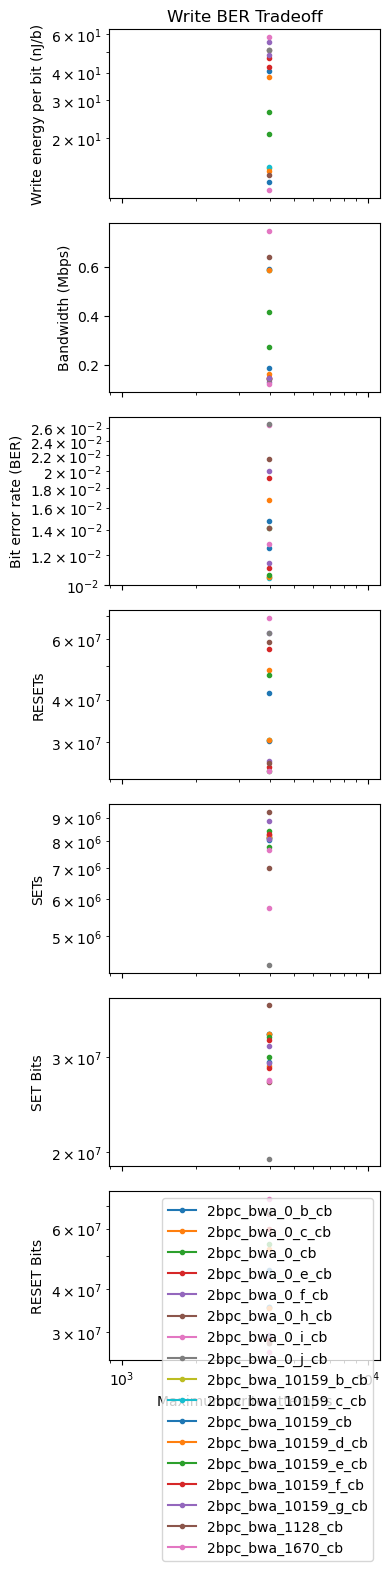

In [ ]:
# Plot write BER tradeoff vs. attempts
fig, axs = plt.subplots(7, 1, figsize=(4,16), sharex=True)
for (bpc, alias), d in data.groupby(["bpc", "alias"]):
  plt.xlabel("Maximum write attempts")
  plt.xscale("log")
  axs[0].set_title(f"Write BER Tradeoff")
  axs[0].plot(d["att"], d["energy_per_bit"]*1e9, ".-", label=alias)
  axs[0].set_yscale("log")
  axs[0].set_ylabel("Write energy per bit (nJ/b)")
  axs[1].plot(d["att"], d["bw"]/1e6, ".-", label=alias)
  axs[1].set_ylabel("Bandwidth (Mbps)")
  axs[2].plot(d["att"], d["ber"], ".-", label=alias)
  axs[2].set_yscale("log")
  axs[2].set_ylabel("Bit error rate (BER)")
  axs[3].plot(d["att"], d["resets"], ".-", label=alias)
  axs[3].set_yscale("log")
  axs[3].set_ylabel("RESETs")
  axs[4].plot(d["att"], d["sets"], ".-", label=alias)
  axs[4].set_yscale("log")
  axs[4].set_ylabel("SETs")
  axs[5].plot(d["att"], d["set_bits"], ".-", label=alias)
  axs[5].set_yscale("log")
  axs[5].set_ylabel("SET Bits")
  axs[6].plot(d["att"], d["reset_bits"], ".-", label=alias)
  axs[6].set_yscale("log")
  axs[6].set_ylabel("RESET Bits")
plt.legend()
plt.tight_layout()
# plt.savefig(f"../analysis/figs/{bpc}bpc_write_ber_tradeoff.pdf")
plt.subplots_adjust(hspace=0.15)
plt.show()